In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import xgboost as xgb
import shap


from pathlib import Path
from scipy import sparse
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier
from xgboost.callback import EarlyStopping
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve


from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    precision_recall_curve
)

# Get project root (one level up from notebooks/)
project_root = Path().resolve().parents[0]

sys.path.append(str(project_root))

sns.set_style("whitegrid")

RANDOM_STATE = 42


In [4]:
# Load the semi-raw dataset

DATA_PATH = Path("../data/processed/telco_churn_semi_raw.csv")
df = pd.read_csv(DATA_PATH)

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customerID          7043 non-null   object 
 1   gender              7043 non-null   object 
 2   SeniorCitizen       7043 non-null   int64  
 3   Partner             7043 non-null   object 
 4   Dependents          7043 non-null   object 
 5   tenure              7043 non-null   int64  
 6   PhoneService        7043 non-null   object 
 7   MultipleLines       7043 non-null   object 
 8   InternetService     7043 non-null   object 
 9   OnlineSecurity      7043 non-null   object 
 10  OnlineBackup        7043 non-null   object 
 11  DeviceProtection    7043 non-null   object 
 12  TechSupport         7043 non-null   object 
 13  StreamingTV         7043 non-null   object 
 14  StreamingMovies     7043 non-null   object 
 15  Contract            7043 non-null   object 
 16  Paperl

In [5]:
# Drop columns not needed for modeling

target_col = "Churn"
id_col = "customerID"  # if present

drop_cols = [target_col]
if id_col in df.columns:
    drop_cols.append(id_col)

X = df.drop(columns=drop_cols)
y = df[target_col].map({"No": 0, "Yes": 1})


In [6]:
# Identify numeric columns automatically (safe for new engineered numeric features)
numeric_features = X.select_dtypes(include=["number"]).columns.tolist()

# Everything else treated as categorical (includes tenure_group)
categorical_features = X.select_dtypes(exclude=["number"]).columns.tolist()

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)

Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'avg_monthly_charge', 'num_services']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'tenure_group']


In [7]:
# Numerical: impute with median + scale
# Categorical: impute most frequent + OneHotEncode

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [8]:
#  split into:
# - Train (used to fit model and preprocessing)
# - Validation (used for model selection & threshold tuning)
# - Test (used once at the end, for final unbiased evaluation)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.25,             # 0.25 of 0.80 = 0.20 -> 60/20/20 split overall
    stratify=y_trainval,
    random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, " | Churn rate:", y_train.mean().round(3))
print("Val size:  ", X_val.shape,   " | Churn rate:", y_val.mean().round(3))
print("Test size: ", X_test.shape,  " | Churn rate:", y_test.mean().round(3))


Train size: (4225, 22)  | Churn rate: 0.265
Val size:   (1409, 22)  | Churn rate: 0.265
Test size:  (1409, 22)  | Churn rate: 0.265


### Functions


In [9]:
def evaluate_at_threshold(model, X_eval, y_eval, threshold=0.5, label="VAL"):
    """
    Evaluate a binary classifier using probabilities + a custom threshold.
    Reports ROC-AUC, PR-AUC, confusion matrix, and classification report.
    """
    proba = model.predict_proba(X_eval)[:, 1]
    preds = (proba >= threshold).astype(int)

    roc = roc_auc_score(y_eval, proba)
    pr_auc = average_precision_score(y_eval, proba)

    print(f"\n[{label}] Threshold = {threshold:.2f}")
    print(f"[{label}] ROC-AUC  = {roc:.4f}")
    print(f"[{label}] PR-AUC   = {pr_auc:.4f}")
    print(f"[{label}] Confusion matrix:\n{confusion_matrix(y_eval, preds)}")
    print(f"[{label}] Classification report:\n{classification_report(y_eval, preds, digits=3)}")

    return {"roc_auc": roc, "pr_auc": pr_auc}


# **Logistic Regression**

## **Experiment 1:** Baseline Logistic Regression

In [12]:
baseline_lr = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", LogisticRegression(
            solver="lbfgs",
            max_iter=1000,
            random_state=RANDOM_STATE
        ))
    ]
)

baseline_lr.fit(X_train, y_train)

# Evaluate on validation at default threshold 0.5
baseline_metrics = evaluate_at_threshold(
    baseline_lr, X_val, y_val, threshold=0.5, label="VAL - Baseline LR"
)



[VAL - Baseline LR] Threshold = 0.50
[VAL - Baseline LR] ROC-AUC  = 0.8402
[VAL - Baseline LR] PR-AUC   = 0.6522
[VAL - Baseline LR] Confusion matrix:
[[942  93]
 [178 196]]
[VAL - Baseline LR] Classification report:
              precision    recall  f1-score   support

           0      0.841     0.910     0.874      1035
           1      0.678     0.524     0.591       374

    accuracy                          0.808      1409
   macro avg      0.760     0.717     0.733      1409
weighted avg      0.798     0.808     0.799      1409



## **Experiment 2:**  Logistic Regression with class_weight="balanced"

In [13]:
balanced_lr = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", LogisticRegression(
            solver="lbfgs",
            max_iter=1000,
            class_weight="balanced",  # emphasize minority class (churn)
            random_state=RANDOM_STATE
        ))
    ]
)

balanced_lr.fit(X_train, y_train)

balanced_metrics = evaluate_at_threshold(
    balanced_lr, X_val, y_val, threshold=0.5, label="VAL - Balanced LR"
)


[VAL - Balanced LR] Threshold = 0.50
[VAL - Balanced LR] ROC-AUC  = 0.8406
[VAL - Balanced LR] PR-AUC   = 0.6531
[VAL - Balanced LR] Confusion matrix:
[[767 268]
 [ 78 296]]
[VAL - Balanced LR] Classification report:
              precision    recall  f1-score   support

           0      0.908     0.741     0.816      1035
           1      0.525     0.791     0.631       374

    accuracy                          0.754      1409
   macro avg      0.716     0.766     0.724      1409
weighted avg      0.806     0.754     0.767      1409



## **Experiment 3:**   Hyperparameter tuning for C (regularization strength)

In [15]:
param_grid = {
    "clf__C": [0.01, 0.1, 1.0, 10.0, 100.0]
}

# Use stratified CV because of class imbalance
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

tune_lr = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", LogisticRegression(
            solver="lbfgs",
            max_iter=1000,
            class_weight="balanced",   # tune C under the balanced setting
            random_state=RANDOM_STATE
        ))
    ]
)

# Optimize for ROC-AUC (ranking quality); later we tune threshold for business metrics
grid = GridSearchCV(
    estimator=tune_lr,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=0
)

grid.fit(X_train, y_train)

print("\nBest LR params (CV):", grid.best_params_)
print("Best CV ROC-AUC:", round(grid.best_score_, 4))

best_lr = grid.best_estimator_

# Evaluate tuned model on validation at threshold 0.5
tuned_metrics = evaluate_at_threshold(
    best_lr, X_val, y_val, threshold=0.5, label="VAL - Tuned LR (balanced + best C)"
)


Best LR params (CV): {'clf__C': 10.0}
Best CV ROC-AUC: 0.8499

[VAL - Tuned LR (balanced + best C)] Threshold = 0.50
[VAL - Tuned LR (balanced + best C)] ROC-AUC  = 0.8409
[VAL - Tuned LR (balanced + best C)] PR-AUC   = 0.6538
[VAL - Tuned LR (balanced + best C)] Confusion matrix:
[[771 264]
 [ 80 294]]
[VAL - Tuned LR (balanced + best C)] Classification report:
              precision    recall  f1-score   support

           0      0.906     0.745     0.818      1035
           1      0.527     0.786     0.631       374

    accuracy                          0.756      1409
   macro avg      0.716     0.766     0.724      1409
weighted avg      0.805     0.756     0.768      1409



## **Experiment 4:**  Threshold tuning on the validation set

In [16]:
# We pick a threshold that optimizes a chosen metric on validation.
# Two common choices:
# - Maximize F1 (balanced trade-off)
# - Maximize Recall subject to Precision >= some minimum (business constraint)

val_proba = best_lr.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, val_proba)

# precision_recall_curve returns thresholds of size (n-1)
# We'll compute F1 for each threshold.
f1_scores = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12)

best_idx = np.argmax(f1_scores)
best_threshold_f1 = thresholds[best_idx]

print("\nBest threshold (maximize F1 on VAL):", round(best_threshold_f1, 4))
print("Precision:", round(precision[best_idx], 4),
      "Recall:", round(recall[best_idx], 4),
      "F1:", round(f1_scores[best_idx], 4))

# Evaluate tuned model at the best threshold on validation
_ = evaluate_at_threshold(
    best_lr, X_val, y_val, threshold=float(best_threshold_f1), label="VAL - Tuned LR @ best F1 threshold"
)



Best threshold (maximize F1 on VAL): 0.6107
Precision: 0.5914 Recall: 0.7005 F1: 0.6414

[VAL - Tuned LR @ best F1 threshold] Threshold = 0.61
[VAL - Tuned LR @ best F1 threshold] ROC-AUC  = 0.8409
[VAL - Tuned LR @ best F1 threshold] PR-AUC   = 0.6538
[VAL - Tuned LR @ best F1 threshold] Confusion matrix:
[[854 181]
 [112 262]]
[VAL - Tuned LR @ best F1 threshold] Classification report:
              precision    recall  f1-score   support

           0      0.884     0.825     0.854      1035
           1      0.591     0.701     0.641       374

    accuracy                          0.792      1409
   macro avg      0.738     0.763     0.747      1409
weighted avg      0.806     0.792     0.797      1409



In [17]:
# Now that we've:
# - Selected the best LR variant
# - Tuned C via CV on train
# - Selected a threshold on validation
# We evaluate on test once for an unbiased estimate.

_ = evaluate_at_threshold(
    best_lr, X_test, y_test, threshold=float(best_threshold_f1), label="TEST - Final LR (Champion for LR family)"
)


[TEST - Final LR (Champion for LR family)] Threshold = 0.61
[TEST - Final LR (Champion for LR family)] ROC-AUC  = 0.8470
[TEST - Final LR (Champion for LR family)] PR-AUC   = 0.6602
[TEST - Final LR (Champion for LR family)] Confusion matrix:
[[833 202]
 [106 268]]
[TEST - Final LR (Champion for LR family)] Classification report:
              precision    recall  f1-score   support

           0      0.887     0.805     0.844      1035
           1      0.570     0.717     0.635       374

    accuracy                          0.781      1409
   macro avg      0.729     0.761     0.740      1409
weighted avg      0.803     0.781     0.789      1409



## **Interpretability**
Extract busines insight from this logistic regression

In [18]:
# Get trained pipeline
final_model = best_lr  # the tuned Logistic model

# Extract preprocessing step
preprocessor = final_model.named_steps["preprocess"]
classifier = final_model.named_steps["clf"]

# Get feature names after transformation
num_features = numeric_features
cat_features = categorical_features

# Get one-hot encoded feature names
ohe = preprocessor.named_transformers_["cat"]["onehot"]
ohe_feature_names = ohe.get_feature_names_out(cat_features)

# Combine numeric + encoded categorical names
all_feature_names = np.concatenate([num_features, ohe_feature_names])

# Extract coefficients
coefficients = classifier.coef_[0]

# Create dataframe for analysis
coef_df = pd.DataFrame({
    "feature": all_feature_names,
    "coefficient": coefficients
})

# Sort by impact
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False)

coef_df.head(15)

,feature,coefficient,abs_coef
18,InternetService_Fiber optic,1.201961,1.201961
1,tenure,-1.089351,1.089351
17,InternetService_DSL,-1.050288,1.050288
40,Contract_Two year,-1.025584,1.025584
4,avg_monthly_charge,-0.976678,0.976678
2,MonthlyCharges,-0.861320,0.861320
38,Contract_Month-to-month,0.806215,0.806215
5,num_services,0.681959,0.681959
3,TotalCharges,0.452581,0.452581
21,OnlineSecurity_No internet service,-0.395052,0.395052


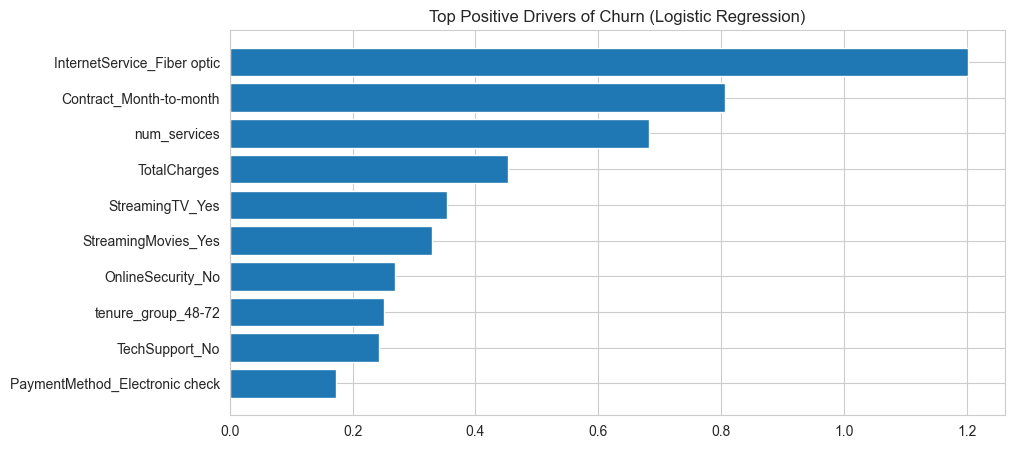

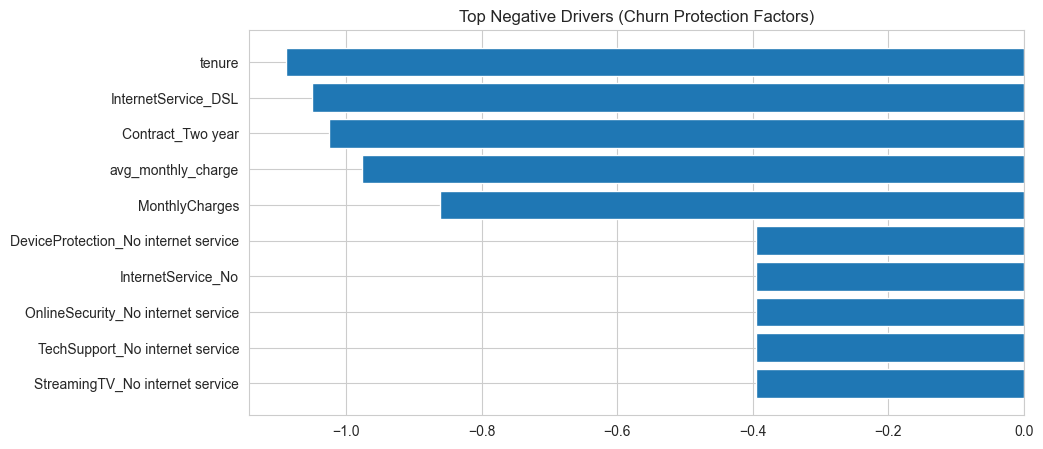

In [ ]:

top_positive = coef_df.sort_values("coefficient", ascending=False).head(10)
top_negative = coef_df.sort_values("coefficient").head(10)

plt.figure(figsize=(10,5))
plt.barh(top_positive["feature"], top_positive["coefficient"])
plt.title("Top Positive Drivers of Churn (Logistic Regression)")
plt.gca().invert_yaxis()
plt.show()

plt.figure(figsize=(10,5))
plt.barh(top_negative["feature"], top_negative["coefficient"])
plt.title("Top Negative Drivers (Churn Protection Factors)")
plt.gca().invert_yaxis()
plt.show()

## Logistic Regression – Interpretability Analysis

To better understand the drivers of churn, we analyzed the model coefficients after preprocessing and standardization.

Because numerical features are scaled, coefficient magnitude is directly comparable across variables.

---

### Top Positive Drivers of Churn (Risk Factors)

The strongest factors increasing churn probability are:

1. **Fiber Optic Internet Service**
   - Strongest positive coefficient.
   - Suggests potential dissatisfaction, higher price sensitivity, or competitive pressure in this segment.

2. **Month-to-Month Contract**
   - Customers without long-term commitment are significantly more likely to churn.
   - Confirms EDA findings.

3. **Number of Services (num_services)**
   - Customers with more subscribed services show higher churn risk.
   - Possibly due to higher billing complexity or cost sensitivity.

4. **Higher Total Charges**
   - Customers who have accumulated larger total payments show increased churn probability.
   - May reflect price-related dissatisfaction.

5. **Streaming Services & Lack of Online Security / Tech Support**
   - Customers without security or support features exhibit higher churn risk.

Overall, these features describe customers with:
- Flexible contracts
- Higher exposure to services
- Potential cost sensitivity

---

### Top Negative Drivers (Protective Factors)

Strongest factors reducing churn probability:

1. **Tenure**
   - The strongest protective factor.
   - Longer relationship → significantly lower churn risk.

2. **DSL Internet Service**
   - Lower churn compared to Fiber users.
   - Possibly more stable or lower-cost segment.

3. **Two-Year Contract**
   - Strong retention effect.
   - Confirms contractual commitment is critical.

4. **Automatic / Stable Billing Patterns**
   - Certain structured payment setups correlate with lower churn.

5. **No Internet Service Indicators**
   - These customers are less exposed to high-risk service categories.


## Logistic Regression – Final Evaluation (Champion within LR family)

### 1. Model Configuration

The final Logistic Regression model was selected after:

- Applying `class_weight="balanced"` to address class imbalance.
- Tuning the regularization strength `C` using cross-validation (optimized for ROC-AUC).
- Performing threshold tuning on the validation set to maximize F1-score.

The final operating threshold selected was:

**Threshold = 0.61**

---

### 2. Test Set Performance

- **ROC-AUC:** 0.847  
- **PR-AUC:** 0.660  
- **Accuracy:** 0.781  

Confusion Matrix:

|               | Predicted No | Predicted Yes |
|---------------|-------------|--------------|
| Actual No     | 833         | 202          |
| Actual Yes    | 106         | 268          |

---

### 3. Churn Class (Positive Class) Performance

- **Precision:** 0.570  
- **Recall:** 0.717  
- **F1-score:** 0.635  

Key interpretation:

- The model correctly identifies **71.7% of churners**.
- 28.3% of churners are still missed.
- 43% of predicted churners are false positives.

Compared to the initial baseline model (recall ≈ 0.56), recall has improved significantly through class balancing and threshold tuning.

---

### 4. Business Interpretation


The model is highly coherent with business logic:

- Commitment (long contracts, long tenure) strongly reduces churn.
- High flexibility (month-to-month) increases churn.
- Fiber customers are particularly at risk.
- Service bundling and price exposure may contribute to churn risk.

Importantly, the model confirms the main EDA hypotheses, increasing confidence in its validity.

---

### 5. Overall Assessment

Logistic Regression demonstrates:

- Strong ranking capability (ROC-AUC 0.847).
- Good recall after threshold tuning.
- Interpretable coefficients.
- Stable and robust behavior.

The problem is clearly learnable with linear decision boundaries.

However, further gains may be achieved using non-linear models (e.g., Random Forest or Gradient Boosting).

# **Random Forest**

## **Experiment 1:** Baseline Random Forest

In [21]:
rf_baseline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]
)

rf_baseline.fit(X_train, y_train)

# Evaluate at default threshold 0.5
_ = evaluate_at_threshold(
    rf_baseline, X_val, y_val, threshold=0.5, label="VAL - RF Baseline"
)


[VAL - RF Baseline] Threshold = 0.50
[VAL - RF Baseline] ROC-AUC  = 0.8167
[VAL - RF Baseline] PR-AUC   = 0.6132
[VAL - RF Baseline] Confusion matrix:
[[930 105]
 [194 180]]
[VAL - RF Baseline] Classification report:
              precision    recall  f1-score   support

           0      0.827     0.899     0.862      1035
           1      0.632     0.481     0.546       374

    accuracy                          0.788      1409
   macro avg      0.729     0.690     0.704      1409
weighted avg      0.775     0.788     0.778      1409



## **Experiment 2:** RF - Handle class imbalance

In [22]:
rf_balanced = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            class_weight="balanced", ## balance classes in RF as well
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]
)

rf_balanced.fit(X_train, y_train)

_ = evaluate_at_threshold(
    rf_balanced, X_val, y_val, threshold=0.5, label="VAL - RF Balanced"
)


[VAL - RF Balanced] Threshold = 0.50
[VAL - RF Balanced] ROC-AUC  = 0.8181
[VAL - RF Balanced] PR-AUC   = 0.6071
[VAL - RF Balanced] Confusion matrix:
[[942  93]
 [198 176]]
[VAL - RF Balanced] Classification report:
              precision    recall  f1-score   support

           0      0.826     0.910     0.866      1035
           1      0.654     0.471     0.547       374

    accuracy                          0.793      1409
   macro avg      0.740     0.690     0.707      1409
weighted avg      0.781     0.793     0.782      1409



## **Experiment 3:** Hyperparameter tuning

Will work with the most impactful parameters: 
- max_depth
- min_samples_leaf
- max_features

In [23]:
param_grid_rf = {
    "clf__max_depth": [None, 5, 10, 20],
    "clf__min_samples_leaf": [1, 5, 10],
    "clf__max_features": ["sqrt", 0.5]
}

rf_tune = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=400,
            class_weight="balanced",
            random_state=RANDOM_STATE,
            n_jobs=-1
        ))
    ]
)

grid_rf = GridSearchCV(
    estimator=rf_tune,
    param_grid=param_grid_rf,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
print("Best RF CV ROC-AUC:", round(grid_rf.best_score_, 4))

best_rf = grid_rf.best_estimator_

# Evaluate tuned RF on validation
_ = evaluate_at_threshold(
    best_rf, X_val, y_val, threshold=0.5, label="VAL - Tuned RF"
)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best RF params: {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 10}
Best RF CV ROC-AUC: 0.8481

[VAL - Tuned RF] Threshold = 0.50
[VAL - Tuned RF] ROC-AUC  = 0.8389
[VAL - Tuned RF] PR-AUC   = 0.6440
[VAL - Tuned RF] Confusion matrix:
[[783 252]
 [ 88 286]]
[VAL - Tuned RF] Classification report:
              precision    recall  f1-score   support

           0      0.899     0.757     0.822      1035
           1      0.532     0.765     0.627       374

    accuracy                          0.759      1409
   macro avg      0.715     0.761     0.724      1409
weighted avg      0.801     0.759     0.770      1409



## **Experiment 4:** Threshold tuning

In [24]:
val_proba_rf = best_rf.predict_proba(X_val)[:, 1]

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_val, val_proba_rf)

f1_rf = (2 * precision_rf[:-1] * recall_rf[:-1]) / (
    precision_rf[:-1] + recall_rf[:-1] + 1e-12
)

best_idx_rf = np.argmax(f1_rf)
best_threshold_rf = thresholds_rf[best_idx_rf]

print("Best RF threshold (F1):", round(best_threshold_rf, 4))
print("Precision:", round(precision_rf[best_idx_rf], 4),
      "Recall:", round(recall_rf[best_idx_rf], 4),
      "F1:", round(f1_rf[best_idx_rf], 4))

Best RF threshold (F1): 0.573
Precision: 0.6023 Recall: 0.7005 F1: 0.6477


In [25]:
_ = evaluate_at_threshold(
    best_rf, X_val, y_val,
    threshold=float(best_threshold_rf),
    label="VAL - RF @ tuned threshold"
)



[VAL - RF @ tuned threshold] Threshold = 0.57
[VAL - RF @ tuned threshold] ROC-AUC  = 0.8389
[VAL - RF @ tuned threshold] PR-AUC   = 0.6440
[VAL - RF @ tuned threshold] Confusion matrix:
[[862 173]
 [113 261]]
[VAL - RF @ tuned threshold] Classification report:
              precision    recall  f1-score   support

           0      0.884     0.833     0.858      1035
           1      0.601     0.698     0.646       374

    accuracy                          0.797      1409
   macro avg      0.743     0.765     0.752      1409
weighted avg      0.809     0.797     0.802      1409



## Interpretability of the best RF Model

In [26]:
# Extract preprocessing step
preprocessor_rf = best_rf.named_steps["preprocess"]
rf_model = best_rf.named_steps["clf"]

# Get feature names
ohe = preprocessor_rf.named_transformers_["cat"]["onehot"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

all_feature_names = np.concatenate([numeric_features, ohe_feature_names])

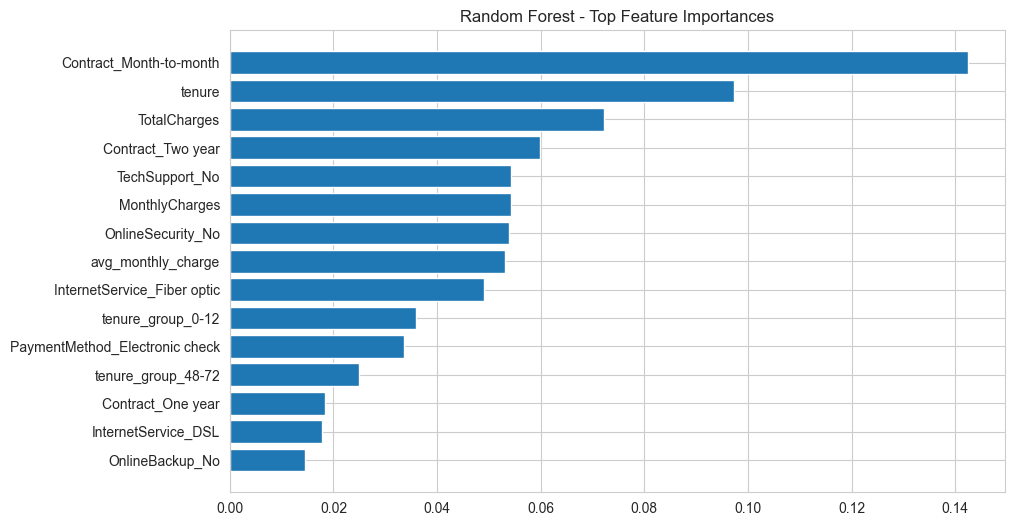

In [27]:

importances = rf_model.feature_importances_

rf_importance_df = pd.DataFrame({
    "feature": all_feature_names,
    "importance": importances
})

rf_importance_df = rf_importance_df.sort_values("importance", ascending=False)

# Plot top 15
top_rf = rf_importance_df.head(15)

plt.figure(figsize=(10,6))
plt.barh(top_rf["feature"], top_rf["importance"])
plt.gca().invert_yaxis()
plt.title("Random Forest - Top Feature Importances")
plt.show()

In [29]:

perm_importance = permutation_importance(
    best_rf,
    X_val,
    y_val,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="roc_auc"
)

perm_df = pd.DataFrame({
    "feature": X_val.columns,
    "importance_mean": perm_importance.importances_mean
}).sort_values("importance_mean", ascending=False)

perm_df.head(15)

,feature,importance_mean
14,Contract,0.044896
7,InternetService,0.023250
4,tenure,0.010609
18,TotalCharges,0.005498
19,tenure_group,0.005129
8,OnlineSecurity,0.004325
17,MonthlyCharges,0.003857
11,TechSupport,0.002877
16,PaymentMethod,0.002088
15,PaperlessBilling,0.002082


## Random Forest – Interpretability Analysis

Both impurity-based and permutation importance analyses confirm
that contract structure is the dominant driver of churn.

### Key Drivers

- Contract type (Month-to-month vs Two-year)
- Internet service type
- Tenure
- Total charges
- Lack of online security or tech support

Permutation importance shows that contract type is by far the most influential feature,
indicating that customer commitment level is the primary determinant of churn.

---

## Comparison with Logistic Regression

Feature rankings are highly consistent with Logistic Regression results.

This suggests:

- The dataset contains strong and stable churn signals.
- Nonlinear effects captured by Random Forest do not drastically alter
  the hierarchy of important features.
- The problem appears largely structured around contract commitment
  and tenure dynamics.

---

## Conclusion

Random Forest interpretability confirms the robustness of core churn drivers.

However, the model does not uncover substantially different patterns
compared to Logistic Regression, which explains the limited performance gain.

## Random Forest – Model Evaluation

After tuning and threshold optimization, Random Forest achieved:

- ROC-AUC: 0.839
- PR-AUC: 0.644
- Recall (Churn): 0.698
- Precision (Churn): 0.601
- F1-score: 0.646

While F1-score slightly improved compared to Logistic Regression,
overall ROC-AUC and PR-AUC remain lower.

The performance gain does not clearly justify the additional model complexity.

---

## Comparison with Logistic Regression

Logistic Regression achieved:

- Higher ROC-AUC (0.847)
- Higher PR-AUC (0.660)
- Slightly better recall
- Comparable F1-score

Given its simplicity, interpretability, and competitive performance,
Logistic Regression remains a strong candidate.

At this stage, Random Forest does not demonstrate a decisive advantage. To explore further, an XGBoost model will be trained and tested.

# **XGBoost**

In [10]:
preprocessor = preprocessor  # reuse the one you already built (ColumnTransformer)

X_train_t = preprocessor.fit_transform(X_train)
X_val_t   = preprocessor.transform(X_val)
X_test_t  = preprocessor.transform(X_test)


In [31]:
# Build DMatrices (required by xgboost.train)
dtrain = xgb.DMatrix(X_train_t, label=y_train)
dval   = xgb.DMatrix(X_val_t, label=y_val)

In [32]:
# Define an XGBoost baseline configuration  (good starting point for churn tabular)
params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.05,
    "max_depth": 4,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 1,
    "reg_lambda": 1.0,
    "random_state": RANDOM_STATE,
}

# Train with early stopping on validation
evals = [(dtrain, "train"), (dval, "val")]

In [33]:
booster = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=5000,          # large, early stopping will choose best
    evals=evals,
    early_stopping_rounds=50,      # stop if no improvement for 50 rounds
    verbose_eval=100               # print every 100 rounds (set False to silence)
)

best_iteration = booster.best_iteration
print("Best iteration (0-based):", best_iteration)
print("Best num_boost_round:", best_iteration + 1)


[0]	train-auc:0.84151	val-auc:0.81792
[100]	train-auc:0.88899	val-auc:0.84028
[139]	train-auc:0.89704	val-auc:0.83911
Best iteration (0-based): 89
Best num_boost_round: 90


In [34]:
# Evaluate on validation
val_proba = booster.predict(dval)
print("VAL ROC-AUC:", roc_auc_score(y_val, val_proba))
print("VAL PR-AUC: ", average_precision_score(y_val, val_proba))

VAL ROC-AUC: 0.8391058926864553
VAL PR-AUC:  0.6496362704708837


In [ ]:

precision, recall, thresholds = precision_recall_curve(y_val, val_proba)
f1 = (2 * precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-12)

best_idx = np.argmax(f1)
best_threshold = float(thresholds[best_idx])

print("Best threshold (VAL, max F1):", best_threshold)
print("Precision:", float(precision[best_idx]),
      "Recall:", float(recall[best_idx]),
      "F1:", float(f1[best_idx]))

Best threshold (VAL, max F1): 0.3948020040988922
Precision: 0.6169154228855721 Recall: 0.6631016042780749 F1: 0.6391752577314594


In [ ]:

dtest = xgb.DMatrix(X_test_t, label=y_test)
test_proba = booster.predict(dtest)

print("TEST ROC-AUC:", roc_auc_score(y_test, test_proba))
print("TEST PR-AUC: ", average_precision_score(y_test, test_proba))

test_pred = (test_proba >= best_threshold).astype(int)
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))

TEST ROC-AUC: 0.845237541656979
TEST PR-AUC:  0.6603926076237552
Confusion matrix:
 [[860 175]
 [128 246]]
              precision    recall  f1-score   support

           0      0.870     0.831     0.850      1035
           1      0.584     0.658     0.619       374

    accuracy                          0.785      1409
   macro avg      0.727     0.744     0.735      1409
weighted avg      0.794     0.785     0.789      1409



## XGBoost – Model Evaluation

XGBoost was trained using early stopping and threshold optimization.

Test performance:

- ROC-AUC: 0.845
- PR-AUC: 0.660
- Recall (Churn): 0.658
- Precision (Churn): 0.584
- F1-score: 0.619

While XGBoost achieved competitive ranking performance,
it did not outperform Logistic Regression in recall or overall F1-score.

The performance difference is marginal and does not justify
the additional model complexity.

---

## Final Model Comparison

Across all experiments:

- Logistic Regression achieved the highest ROC-AUC.
- It also achieved the highest recall for churn.
- Random Forest and XGBoost provided only marginal differences.

Given its interpretability, simplicity, and strong performance,
Logistic Regression is selected as the final champion model.

## XGBoost SHAP

In [41]:
# Get feature names after preprocessing (one-hot encoding)

pre = preprocessor  # your fitted ColumnTransformer from the XGBoost training block

# Numeric features (same list you used)
num_features = numeric_features

# One-hot feature names
ohe = pre.named_transformers_["cat"]["onehot"]
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

feature_names = np.concatenate([num_features, ohe_feature_names])

In [43]:
## Prepare a SHAP dataset (a sample of the validation set, transformed and in the right format for SHAP)

# Use the already transformed validation matrix (X_val_t) you created for XGBoost
X_shap = X_val_t

# Ensure CSR format (often best for sparse matrices)
if sparse.issparse(X_shap):
    X_shap = X_shap.tocsr()

# Sample for speed (e.g., 1000 rows)
n_sample = min(1000, X_shap.shape[0])
rng = np.random.default_rng(42)
idx = rng.choice(X_shap.shape[0], size=n_sample, replace=False)

X_shap_sample = X_shap[idx]

In [44]:
#  SHAP explainability for XGBoost booster
# 'booster' is your trained model from xgb.train(...)
explainer = shap.TreeExplainer(booster)

# SHAP values for the sample
shap_values = explainer.shap_values(X_shap_sample)

### Beeswarm

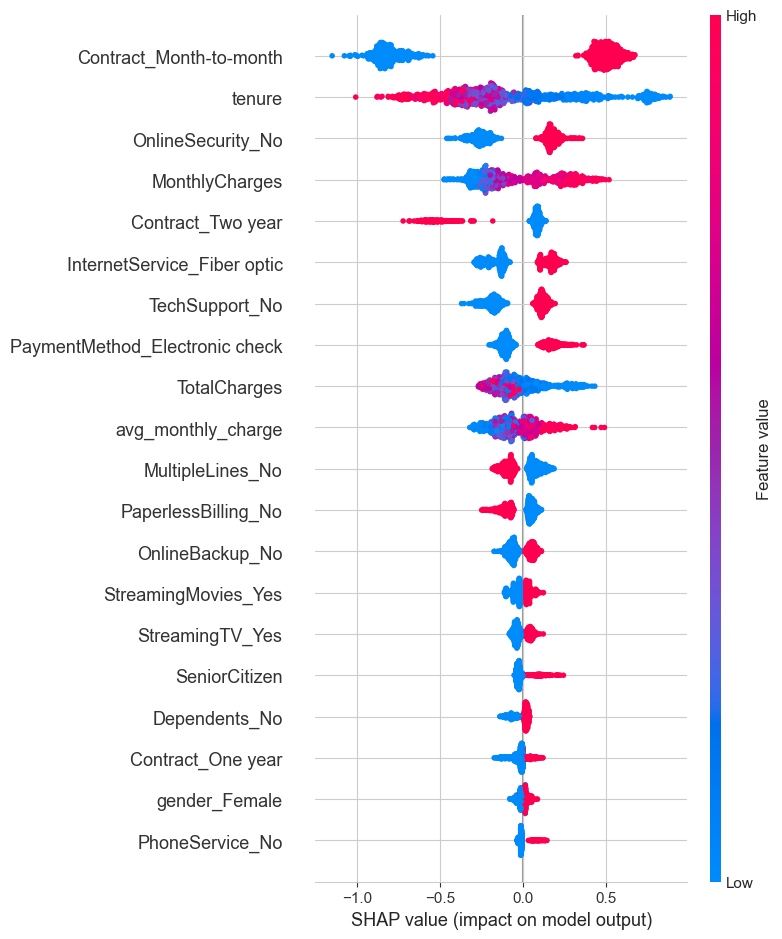

In [45]:
# Summary plot (beeswarm): shows distribution of SHAP values per feature
shap.summary_plot(
    shap_values,
    X_shap_sample,
    feature_names=feature_names,
    max_display=20
)

### Importance bar plot

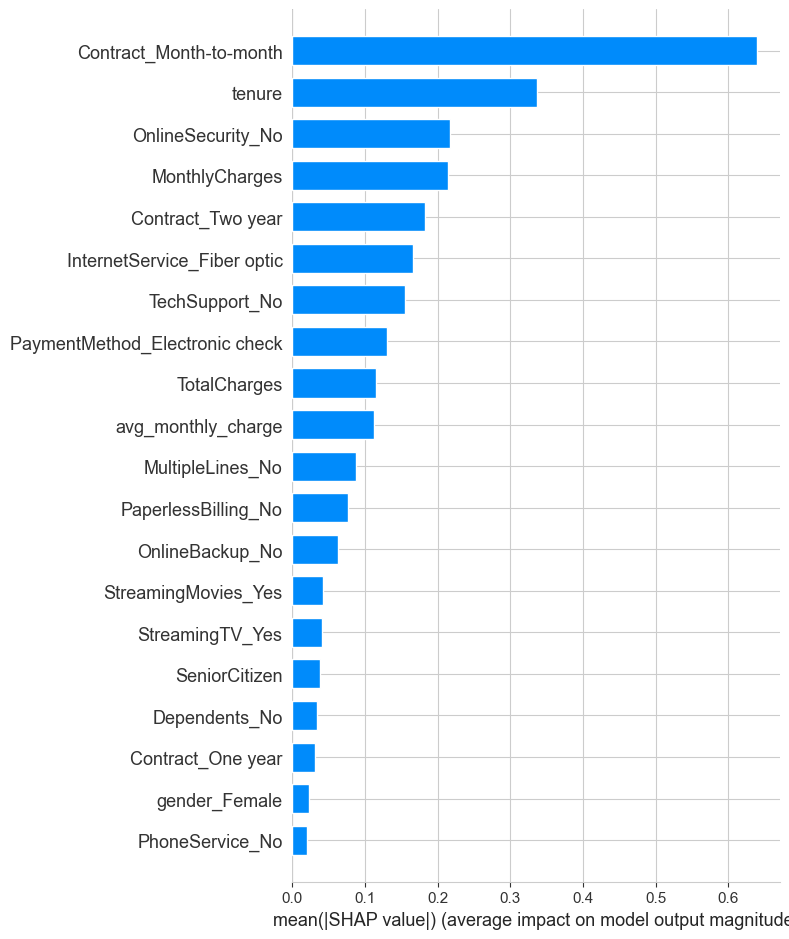

In [46]:
shap.summary_plot(
    shap_values,
    X_shap_sample,
    feature_names=feature_names,
    plot_type="bar",
    max_display=20
)

### SHAP dependence plot

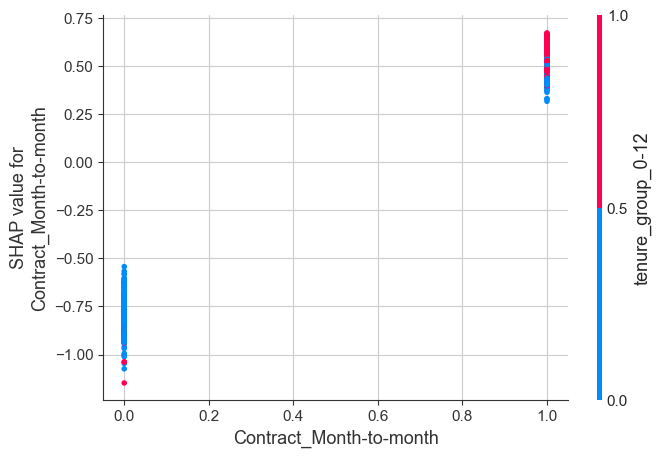

In [47]:
# Example dependence plot
shap.dependence_plot(
    "Contract_Month-to-month",
    shap_values,
    X_shap_sample,
    feature_names=feature_names
)

## XGBoost – SHAP Interpretability Analysis

To better understand how XGBoost makes predictions, SHAP (SHapley Additive exPlanations) values were computed.

SHAP provides a theoretically grounded way to decompose each prediction into additive feature contributions:

Prediction = Baseline + Sum of SHAP values

For a binary classification model (`binary:logistic`):

- Positive SHAP values push the prediction toward churn.
- Negative SHAP values push the prediction toward non-churn.
- The magnitude reflects the strength of the feature’s impact.

---

## 1. Global Feature Importance

The SHAP summary bar plot shows the average absolute contribution of each feature across all observations.

Top drivers of churn according to XGBoost:

1. Contract_Month-to-month
2. tenure
3. OnlineSecurity_No
4. MonthlyCharges
5. Contract_Two year
6. InternetService_Fiber optic
7. TechSupport_No
8. PaymentMethod_Electronic check

The dominance of contract structure and tenure confirms findings from:

- Exploratory Data Analysis
- Logistic Regression coefficients
- Random Forest feature importance

This consistency strengthens confidence in the robustness of the dataset signal.

---

## 2. Directional Effects (Beeswarm Plot)

The SHAP beeswarm plot provides insight into both magnitude and direction of impact.

### Contract_Month-to-month
- When equal to 1, SHAP values are strongly positive.
- This significantly increases churn probability.
- When equal to 0, SHAP values are negative, reducing churn risk.

This confirms that lack of contractual commitment is the strongest churn driver.

---

### Tenure
- Low tenure values (new customers) generate positive SHAP values.
- High tenure values generate negative SHAP values.

This indicates that customer longevity strongly protects against churn.

---

### OnlineSecurity_No
- Customers without online security show positive SHAP contributions.
- Indicates higher churn likelihood for less engaged or less protected users.

---

### MonthlyCharges
- Higher monthly charges push predictions toward churn.
- Lower charges reduce churn probability.

This highlights price sensitivity as an important factor.

---

## 3. Interaction Effects

The SHAP dependence plot for `Contract_Month-to-month` reveals interaction patterns:

- Customers with month-to-month contracts show high positive SHAP values.
- The effect is amplified for customers with low tenure.

This demonstrates that XGBoost captures nonlinear interactions such as:

"Short tenure + Month-to-month contract → Very high churn risk"

Such interactions are not explicitly modeled in Logistic Regression.

---

## 4. Overall Interpretation

SHAP analysis confirms that churn is primarily driven by:

- Contract commitment
- Customer tenure
- Pricing exposure
- Lack of value-added services (security, support)

Importantly, the feature hierarchy remains consistent across:

- Logistic Regression
- Random Forest
- XGBoost

This indicates that the dataset contains strong, stable, and largely linear predictive signals.

While XGBoost captures some interaction effects, these do not substantially change the ranking structure of key drivers.

---

## Conclusion

The SHAP analysis increases confidence in model validity by:

- Confirming business-aligned drivers of churn.
- Demonstrating consistent feature importance across model families.
- Revealing limited additional nonlinear gain from boosting.

This supports the decision to select a simpler and more interpretable model (Logistic Regression) as the final production candidate.